In [1]:
# 以多项式回归为例子来研究过拟合和欠拟合
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree) # 分配大量的空间
true_w[0:4] = np.array([5, 1.2,-3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)

poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
    
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
         torch.float32) for x in [true_w, features, poly_features, labels]]

In [4]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.0935],
         [-0.3207]]),
 tensor([[ 1.0000e+00,  1.0935e+00,  5.9792e-01,  2.1795e-01,  5.9585e-02,
           1.3032e-02,  2.3752e-03,  3.7105e-04,  5.0720e-05,  6.1628e-06,
           6.7393e-07,  6.6998e-08,  6.1054e-09,  5.1358e-10,  4.0116e-11,
           2.9246e-12,  1.9989e-13,  1.2858e-14,  7.8116e-16,  4.4960e-17],
         [ 1.0000e+00, -3.2075e-01,  5.1440e-02, -5.4998e-03,  4.4101e-04,
          -2.8291e-05,  1.5124e-06, -6.9299e-08,  2.7784e-09, -9.9021e-11,
           3.1761e-12, -9.2611e-14,  2.4754e-15, -6.1076e-17,  1.3993e-18,
          -2.9921e-20,  5.9983e-22, -1.1317e-23,  2.0167e-25, -3.4045e-27]]),
 tensor([5.5452, 4.5532]))

In [5]:
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,
            num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                        evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9942627  1.1947476 -3.371851   5.63387  ]]


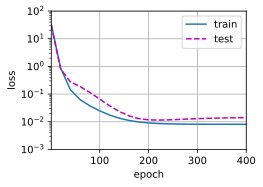

In [7]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.6758246 5.604609 ]]


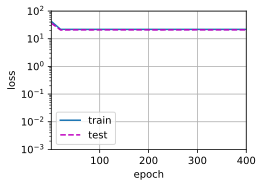

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
                labels[:n_train], labels[n_train:])

weight: [[ 4.9713345   1.2622191  -3.2730124   5.365891   -0.38173628  0.38396695
   0.34825954 -0.38705054  0.04775442 -0.07930315  0.00656984  0.14731725
   0.06315775  0.15579072  0.13342173 -0.16937627  0.09552101 -0.14962797
   0.19817847 -0.04890876]]


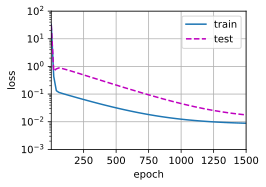

In [9]:
# 过拟合
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:], num_epochs=1500)